In [1]:
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from environment3 import LifeStyleEnv
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.callbacks import EvalCallback
from MaskableA2C import MaskableA2C
from stable_baselines3.common.torch_layers import CombinedExtractor

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def mask_fn(env: gym.Env) -> np.ndarray:
    unwrapped_env = env
    while hasattr(unwrapped_env, "env"):
        unwrapped_env = unwrapped_env.env
    return unwrapped_env.action_masks()

def make_env():
    env = LifeStyleEnv()
    env = Monitor(env)
    check_env(env, warn=True) 
    return env 

env = make_env()
env = ActionMasker(env, mask_fn)

eval_env = make_env()
eval_env = ActionMasker(eval_env, mask_fn)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/a2c/a2c_best_model",
    log_path="./logs/a2c/a2c_results",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

model = MaskableA2C(
    "MultiInputPolicy",  
    env,
    learning_rate=0.0005,
    n_steps=20,           
    gamma=0.95,
    gae_lambda=0.95,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    device=device,
    policy_kwargs=dict(
        features_extractor_class=CombinedExtractor,  
        features_extractor_kwargs={},                
        net_arch=[256, 256]
    ),
    tensorboard_log="./logs/a2c/a2c_tensorboard/"
)

model.learn(total_timesteps=800000, callback=eval_callback)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using device: cuda
Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c/a2c_tensorboard/A2C_2
------------------------------------
| time/                 |          |
|    fps                | 556      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.11    |
|    explained_variance | 0.00141  |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 40.4     |
|    value_loss         | 1.68e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.3e+03  |
|    ep_rew_mean        | 1.51e+04 |
| time/                 |          |
|    fps                | 589      |
|    iterations         | 200      |
|    time_elapsed       | 6        |
|    total_timesteps    | 4000     |
| train/                |        

In [4]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.maskable.utils import get_action_masks
import numpy as np
from MaskableA2C import MaskableA2C

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

model = MaskableA2C.load("logs/a2c/a2c_best_model/best_model.zip")

eval_env = make_env(is_eval=True)

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action_masks = get_action_masks(unwrapped_env)
        action, _ = model.predict(obs, deterministic=True, action_masks=action_masks)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 24.22    | 46.00    | 54.00    | 48.00    | 0.00         | 66.15        | 1.11     |
| 0   | 2          | 8          | sleep      | 24.22    | 42.00    | 58.00    | 46.00    | 0.00         | 132.30       | 2.41     |
| 0   | 3          | 8          | sleep      | 24.22    | 38.00    | 62.00    | 44.00    | 0.00         | 198.45       | 3.69     |
| 0   | 4          | 8          | sleep      | 24.22    | 34.00    | 66.00    | 42.00    | 0.00         | 264.60       | 4.95     |
| 0   | 5          | 8          | sleep    

Contents of the NPZ file: ['timesteps', 'results', 'ep_lengths']


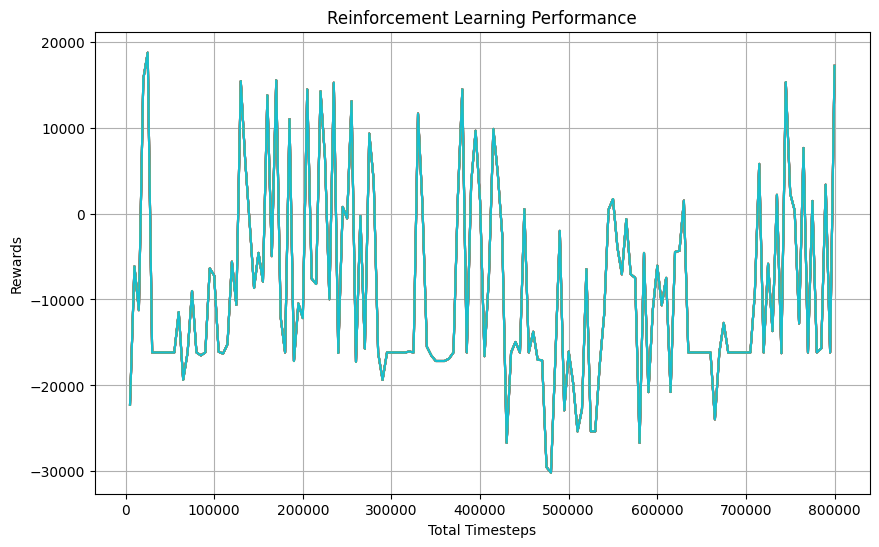

In [7]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'logs/a2c/a2c_results/evaluations.npz'

try:
    data = np.load(file_path)
    print(f"Contents of the NPZ file: {data.files}")
    timesteps = data['timesteps']
    results = data['results']

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, results)

    plt.title('Reinforcement Learning Performance')
    plt.xlabel('Total Timesteps')
    plt.ylabel('Rewards')
    plt.grid(True)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except KeyError as e:
    print(f"Error: The key {e} was not found in the NPZ file. Check the contents using data.files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")